# Bayesian Optimization of Model Hyperparameters

One tricky and important part of building a machine learning model is to choose the set of hyper parameter values that optimize the model's performance against a dataset. For example, for random forests, we have to choose how many decision trees to use and the maximum depth of each decision tree in addition to many others. Tuning these hyper parameters usually involves performing a cross validated grid search which can consume a lot of computational resources, especially if large datasets and complex models such as deep neural networks are involved.

<a href="https://en.wikipedia.org/wiki/Bayesian_optimization" target="_blank">Bayesian optimization</a> is an algorithm used to find a set of parameters that globally optimizes (that is, maximize or minimize) a black box function. This black box function usually requires a lot of time and resources to compute, making it difficult to try out every single possible combination of parameters, as would be the case in a grid search. Typical black box functions include resource intensive computations such as deep learning model hyper parameter searches. By using Bayesian optimization, we can speed up this search process significantly, thus saving time and resources. In this post, we will take a look at Bayesian optimization in Python and using it to optimize the hyper parameter search process.

## The Bayesian Optimization Algorithm

In Bayesian optimization there are 3 important components within the optimization algorithm:

1. The black box function to optimize: _f_(_x_). The black box function is also sometimes called the objective function or the target function, or the loss function depending on the problem. 

2. The acquisition function: _a_(_x_), which is used to generate new parameter data points for further evaluation with the black box function. The point which optimizes the black box function is selected as the best candidate for global optimization.

3. The parameter search space: _x_. If possible, with some amount of intuition or experience, this should be limited if possible to further reduce the time spent on searching.

The optimization process itself is as follows:

1. Define the black box function _f_(_x_), the acquisition function _a_(_x_) and the parameter _x_ search space `[x_low, x_high]`.

2. Generate a set of parameters _x_ from uniform random numbers, and obtain the corresponding output of the black box function _f_(_x_).

3. Fit a <a href="https://en.wikipedia.org/wiki/Kriging" target="_blank">Gaussian process regressor</a> on _X_ = _x_ and _y_ = _f_(_x_). 

4. Generate synthetic values of _x_ within the bounds of [x_low, x_high]. Using the Gaussian process regressor, predict the corresponding values of the black box function _f_(_x_). The specific values of _x_ which lead to the largest predict value of _f_(_x_) are suggested as the next set _x_ to evaluate with the black box function _f_(_x_). 

5. Repeat the optimization process in steps 3 and 4 until we finally get _x_ that leads to the maximum value of _f_(_x_). Note that from the second iteration onwards, all historical values of _x_ and _f_(_x_) should be used to train the Gaussian process regressor. As the number of data points increases, the Gaussian process regressor becomes better at predicting the maximum value of _f_(_x_).

## The <a href="https://github.com/fmfn/BayesianOptimization" target="_blank">bayes_opt</a> Library

As part of this demonstration, we use the <a href="https://github.com/fmfn/BayesianOptimization" target="_blank">bayes_opt</a> library to perform the hyper parameter search for the hyper parameter `C` of a `LogisticRegression` model trained on the `sklearn` breast cancer dataset. The loss function _f_(_x_) used is the ROC AUC score which we want to maximize in order to get the best performing model, by default the acquisition function _a_(_x_) used is the upper confidence bounds function `"ucb"` which takes the form: `a = mean + kappa * std` from the Gaussian process regressor's predictions of _f_(_x_) where we set `kappa = 1.0`. We perform a search for the hyper parameter `C` for the range `[0.1, 10]`. The code is as follows:

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from bayes_opt import BayesianOptimization, UtilityFunction

import warnings
warnings.filterwarnings("ignore")

# Prepare data set for demonstration.
cancer = load_breast_cancer()
X = cancer["data"]
y = cancer["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, 
                                                    random_state = 0)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the metric to optimize over.
def black_box_function(C):
    # Function to maximize using Bayesian optimization.
    model = LogisticRegression(C = C)
    model.fit(X_train_scaled, y_train)
    y_score = model.predict_proba(X_test_scaled)[:, 1]
    f = roc_auc_score(y_test, y_score)
    return f

# Set range of C to optimize over. bayes_opt requires this to be a dictionary.
pbounds = {"C": [0.1, 10]}

# Create BayesianOptimization object, and optimize (maximize) black_box_function.
optimizer = BayesianOptimization(f = black_box_function, 
                                 pbounds = pbounds, 
                                 verbose = 2, 
                                 random_state = 0)

optimizer.maximize(init_points = 5, n_iter = 10)

print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.9901   |  5.533    |
|  2        |  0.9904   |  7.18     |
|  3        |  0.9901   |  6.067    |
|  4        |  0.9901   |  5.494    |
|  5        |  0.9895   |  4.294    |
|  6        |  0.9908   |  8.341    |
|  7        |  0.991    |  9.504    |
|  8        |  0.9727   |  0.1      |
|  9        |  0.991    |  10.0     |
|  10       |  0.9908   |  9.019    |
|  11       |  0.991    |  9.77     |
|  12       |  0.991    |  9.626    |
|  13       |  0.991    |  9.888    |
|  14       |  0.991    |  9.627    |
|  15       |  0.9906   |  7.894    |
Best result: {'C': 9.504174528665441}; f(x) = 0.9909853249475891.


From the results above, the optimizer managed to determine that using the hyper parameter value of `C = 9.504` results in the best performing model!

Instead of using the simple workflow shown above, `bayes_opt` also allows for more control over the optimization process. In this case, we have to manually perform each optimization iteration in a for loop. Inside this for loop we can add additional code to perform other calculations if required.

Note that this time round, `black_box_function` is not passed to the optimizer object directly. This is because we will call the `black_box_function` directly within the for loop.

In [2]:
# Create optimizer and utility function objects.
optimizer = BayesianOptimization(f = None, pbounds = {"C": [0.1, 10]}, verbose = 2, random_state = 0)
utility = UtilityFunction(kind = "ucb", kappa = 1.96, xi = 0.01)

# Optimization for loop.
for i in range(15):
    # Get optimizer to suggest a new parameter value to try.
    next_point = optimizer.suggest(utility)
    # Evaluate the output of the black_box_function using the new parameter value.
    target = black_box_function(**next_point)
    try:
        # Update the optimizer with the evaluation results. This needs to be in try-except
        # to prevent repeat errors from occuring.
        optimizer.register(params = next_point, target = target)
    except:
        pass
    
print("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))

Best result: {'C': 10.0}; f(x) = 0.991.


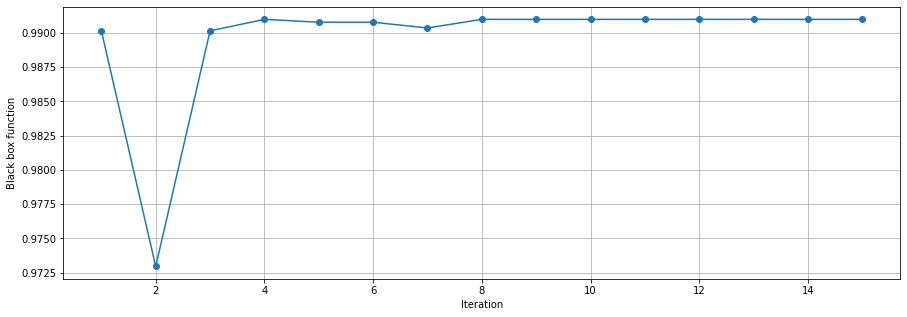

In [3]:
plt.figure(figsize = (15, 5))
plt.plot(range(1, 1+len(optimizer.space.target)), optimizer.space.target, "-o")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Black box function")
plt.show()

## The <a href="https://scikit-optimize.github.io/stable/" target="_blank">scikit-optimize</a> Library

The <a href="https://scikit-optimize.github.io/stable/" target="_blank">scikit-optimize</a> is another Bayesian optimization library closely related to the `scikit-learn` library. Both libraries have very similar Bayesian optimization functionalities, although `scikit-optimize` has a wider range of other capabilities.

We repeat the demonstration above using `scikit-optimize` here. The main difference between `bayes_opt` and `scikit-optimize` is that `bayes_opt` performs maximization, while `scikit-optimize` performs minimization. Therefore, we will need to use the negative of `black_box_function` here.

In [4]:
import skopt

# Unlike bayes_opt, skopt requires that the search boundary is given as an array of tuples.
p_bounds = [(0.1, 10.0)]

opt = skopt.Optimizer(dimensions = p_bounds,
                base_estimator = "GP", # Gaussian Process regressor.
                n_initial_points = 5, 
                initial_point_generator = 'random', 
                acq_func = "LCB", # Lower Confidence Bounds.
                random_state = 0)

for i in range(15):
    next_point_to_try = opt.ask() # next_point is returned as a list.
    # Unlike bayes_opt, skopt performs minimization. Therefore we use -black_box_function(*next_point).
    loss_to_minimize = -black_box_function(*next_point_to_try)
    result = opt.tell(next_point_to_try, loss_to_minimize)
    
# Again, don't forget to use the negative of result as we are performing minimization here.
print("Best result: {}, f(x) = {:.3f}.".format(result["x"], -result["fun"]))

Best result: [10.0], f(x) = 0.991.


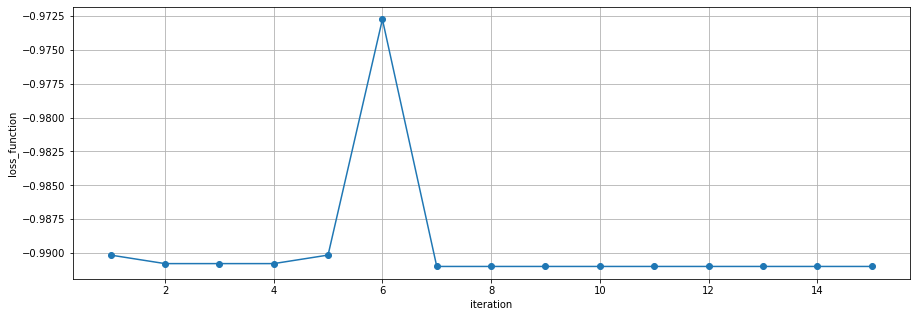

In [5]:
plt.figure(figsize = (15, 5))
plt.plot(range(1, len(result["func_vals"])+1), result["func_vals"], "-o")
plt.grid(True)
plt.xlabel("iteration")
plt.ylabel("loss_function")
plt.show()

Although this demonstration uses an extremely simple setup and makes many simplifications to the modeling process (such as not using cross validation), it depicts how Bayesian optimization can speed up the search process for the best set of hyper parameters to use in a machine learning model. For small datasets or simple models, the speed up might not be significant. However for extremely large datasets or deep neural networks, it might become economically unfeasible to test every point of the hyper parameter grid, and using optimization techniques will improve the efficiency of the hyper parameter search process.